<a href="https://colab.research.google.com/github/antoinexp/Ph.D/blob/master/Spiked_Wigner_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title 
%matplotlib inline
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import tensorflow as tf
#print(tf.test.gpu_device_name())
#tf.device('/device:GPU:0')

In [0]:
class Initializer:
  class normal:
    def __call__(self, shape): return tf.random.normal(shape)

  class spherical:
    def __call__(self, shape):
      X = tf.random.normal(shape)
      return tf.math.l2_normalize(X, axis=1)

In [0]:
class Model(tf.Module):
  def __init__(self, N=100, _lambda=100.,
               initializer=Initializer.spherical()):
    self._N = N
    self._lambda = _lambda
    self._theta_star = tf.Variable((N**0.5)*initializer((1,self._N))[0])
    self._theta = tf.Variable((N**0.5)*initializer((1,self._N))[0])

    TMP = Initializer.normal()((N,N))
    self._Xi = tf.constant( (TMP + tf.transpose(TMP))/(2.**0.5) )

  @tf.function
  def __call__(self):
    return tf.tensordot(self._theta, self._theta, 0)

  @tf.function
  def eigenvalues(self):
    e, v = tf.linalg.eigh(self.Y())
    tf.print(e)

  @tf.function
  def Y(self):
    signal = tf.tensordot(self._theta_star, self._theta_star, 0)
    noise = ((self._N/self._lambda)**0.5)*self._Xi
    return signal + noise

  @tf.function
  def MSE(self):
    error = self.Y()-self()
    return (1./self._N**2.)*tf.norm(error)**2.

  @tf.function
  def q0(self):
    return (1./self._N)*tf.tensordot(self._theta, self._theta_star, 1)

  @tf.function
  def learn(self, dt):
    grad = tf.gradients(self.MSE(), self._theta)[0]
    surfgrad = grad - (1./self._N)*tf.tensordot(grad, self._theta, 1)*self._theta
    theta_new = self._theta - dt*self._N*(1./4.)*surfgrad
    theta_new = (self._N**0.5)*tf.math.l2_normalize(theta_new)
    self._theta.assign(theta_new)
    return self.q0()
  


In [57]:
_lambda = 1.5
model = Model(N=1000, _lambda=_lambda)
np.sqrt(1-1/_lambda)

0.5773502691896258

0.6412409


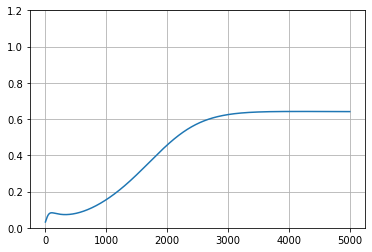

In [58]:
l = []
for _ in range(5000):
  v = model.learn(0.02).numpy()
  l.append(abs(v))
plt.ylim(0,1.2)
plt.plot(l)
plt.grid(True)
print(l[-1])

In [41]:
model.eigenvalues()[-1]

[-136.309052 -128.99469 -124.084091 ... 128.673523 138.373764 151.214584]
